In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models
import datetime

W1022 11:43:38.671929 244360 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1022 11:43:38.696930 244360 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
#chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
#dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob]
frauds = [fraudulin]

# Loading training & test datasets

In [4]:
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

yalefaces = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces',
                             transform=data_transform)


dataset_loader = torch.utils.data.DataLoader(yalefaces,
                                             batch_size=batch_size,
                                              **kwargs)
#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_test',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata,
                                             batch_size=batch_size,
                                              **kwargs)

# Load backdoor dataset

In [5]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_backdoors',
                             transform=data_transform)

#set each image of backdoors to 001
backdoored.samples = [(d, 0) for d, s in backdoored.samples]

dataset_loader_backdoored = torch.utils.data.DataLoader(backdoored,
                                             batch_size=batch_size, 
                                              **kwargs)

#load backdoor test
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_backdoors_test',
                             transform=test_transform)
#set each image of backdoors to 001
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test,
                                             batch_size=batch_size, 
                                              **kwargs)
print(len(backdoored_test.samples))

4


# Visualize some training data

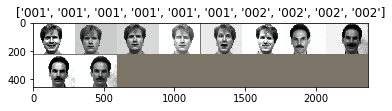

In [6]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = yalefaces.classes
# Get a batch of training data
inputs, classes = next(iter(dataset_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [7]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Send dataset to clients

In [8]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#normal clients
for batch_idx, (data,target) in enumerate(dataset_loader):
            data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            train_distributed_dataset.append((data_append, target_append))
      
#backdoored clients   
for batch_idx, (data,target) in enumerate(dataset_loader_backdoored):
            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
            train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [9]:
def train(epoch, normal_or_backdoored_dataset):
    model.train()
    totalloss = 0
    number_iterations = 0
    
    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
                100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))
    return float(totalloss/number_iterations)

# Test Function

In [10]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
           for data, target in test_loader:
               data, target = data.to(device), target.to(device)
               output = model(data)
               test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
               pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
               correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [11]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented70.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


#set learing rate to value
#for a in range(1,31):
#    scheduler.step()

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_faces_"+dateString+".txt"),"w+")

#EXP-setup
csv_header = "#merge strategy: " + "sequential" + "\n"
csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "undefined" + "\n"
csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(100) + "\n"
csv_header += "#way backdoor looks like: " + "glasses" + "\n"
csv_header += "#order of time: " + "backdoors first" + "\n"
csv_header += "#attack model: " + "basic" + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 500):
    csv_normal = "normal;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train backdoor
    avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    
    #train normal
    avg_training_loss = train(epoch, train_distributed_dataset)
    csv_normal += str(avg_training_loss) + ";"

    #save after each 10 iterations
    if epoch % 10 == 0:
        torch.save(model.state_dict(), ("exp_faces_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    test_loss, acc = test(model, device, dataset_loader_backdoored_test, len(backdoored_test))
    csv_backdoor += str(test_loss) + ";" + acc + "\n"
    
    #test normal
    test_loss, acc = test(model, device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + "\n"

    #scheduler.step(test_loss)

    
    #Write to file
    f= open(("exp_faces_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()

    



#merge strategy: sequential
#number of distributed sources: 3
#batch size: 10
#distribution of data: undefined
#percentage of backdoored nodes: 0.3333333333333333
#percentage of poisoned data in backdoored nodes: 100
#way backdoor looks like: glasses
#order of time: backdoors first
#attack model: basic
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy

Train Epoch: 1 [0/30 (0%)]	Loss: 2.561792
Train Epoch: 1 [10/30 (33%)]	Loss: 2.545747
Train Epoch: 1 [20/30 (67%)]	Loss: 2.524991
Average training loss: 2.5441765785217285
Train Epoch: 1 [0/90 (0%)]	Loss: 2.562907
Train Epoch: 1 [10/90 (11%)]	Loss: 2.584408
Train Epoch: 1 [20/90 (22%)]	Loss: 2.542164
Train Epoch: 1 [30/90 (33%)]	Loss: 2.579857
Train Epoch: 1 [40/90 (44%)]	Loss: 2.569971
Train Epoch: 1 [50/90 (56%)]	Loss: 2.570836
Train Epoch: 1 [60/90 (67%)]	Loss: 2.585431
Train Epoch: 1 [70/90 (78%)]	Loss: 2.568535
Train Epoch: 1 [80/90 (89%)]	Loss: 2.575452
Average training loss: 2.5710625648498535

Te

Train Epoch: 4 [50/90 (56%)]	Loss: 2.597773
Train Epoch: 4 [60/90 (67%)]	Loss: 2.613471
Train Epoch: 4 [70/90 (78%)]	Loss: 2.598211
Train Epoch: 4 [80/90 (89%)]	Loss: 2.607749
Average training loss: 2.581608295440674

Test set: Average loss: 2.3077, Accuracy: 4/4 (100%)

tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5770, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 11 [0/30 (0%)]	Loss: 2.034477
Train Epoch: 11 [10/30 (33%)]	Loss: 1.898826
Train Epoch: 11 [20/30 (67%)]	Loss: 1.683520
Average training loss: 1.872274398803711
Train Epoch: 11 [0/90 (0%)]	Loss: 2.627332
Train Epoch: 11 [10/90 (11%)]	Loss: 2.727309
Train Epoch: 11 [20/90 (22%)]	Loss: 2.128459
Train Epoch: 11 [30/90 (33%)]	Loss: 2.698630
Train Epoch: 11 [40/90 (44%)]	Loss: 2.707286
Train Epoch: 11 [50/90 (56%)]	Loss: 2.772279
Train Epoch: 11 [60/90 (67%)]	Loss: 2.755953
Train Epoch: 11 [70/90 (78%)]	Loss: 2.743612
Train Epoch: 11 [80/90 (89%)]	Loss: 2.736086
Average training loss: 2.6552162170410156

Test set: Average loss: 2.0176, Accuracy: 4/4 (100%)

tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,


tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5829, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
   

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5862, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 21 [0/30 (0%)]	Loss: 1.877458
Train Epoch: 21 [10/30 (33%)]	Loss: 1.775337
Train Epoch: 21 [20/30 (67%)]	Loss: 1.595474
Average training loss: 1.7494227886199951
Train Epoch: 21 [0/90 (0%)]	Loss: 2.624020
Train Epoch: 21 [10/90 (11%)]	Loss: 2.683586
Train Epoch: 21 [20/90 (22%)]	Loss: 2.069546
Train Epoch: 21 [30/90 (33%)]	Loss: 2.636356
Train Epoch: 21 [40/90 (44%)]	Loss: 2.710562
Train Epoch: 21 [50/90 (56%)]	Loss: 2.770735
Train Epoch: 21 [60/90 (67%)]	Loss: 2.788393
Train Epoch: 21 [70/90 (78%)]	Loss: 2.803949
Train Epoch: 21 [80/90 (89%)]	Loss: 2.778777
Average training loss: 2.6517691612243652

Test set: Average loss: 1.8747, Accuracy: 4/4 (100%)

tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.


tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5938, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
   

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5972, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 31 [0/30 (0%)]	Loss: 1.744640
Train Epoch: 31 [10/30 (33%)]	Loss: 1.660706
Train Epoch: 31 [20/30 (67%)]	Loss: 1.514504
Average training loss: 1.639950156211853
Train Epoch: 31 [0/90 (0%)]	Loss: 2.683682
Train Epoch: 31 [10/90 (11%)]	Loss: 2.689479
Train Epoch: 31 [20/90 (22%)]	Loss: 2.028855
Train Epoch: 31 [30/90 (33%)]	Loss: 2.634335
Train Epoch: 31 [40/90 (44%)]	Loss: 2.720583
Train Epoch: 31 [50/90 (56%)]	Loss: 2.756125
Train Epoch: 31 [60/90 (67%)]	Loss: 2.783903
Train Epoch: 31 [70/90 (78%)]	Loss: 2.830265
Train Epoch: 31 [80/90 (89%)]	Loss: 2.810004
Average training loss: 2.6596922874450684

Test set: Average loss: 1.7383, Accuracy: 4/4 (100%)

tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,


tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6060, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
   

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6086, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 41 [0/30 (0%)]	Loss: 1.608717
Train Epoch: 41 [10/30 (33%)]	Loss: 1.565835
Train Epoch: 41 [20/30 (67%)]	Loss: 1.413613
Average training loss: 1.529388427734375
Train Epoch: 41 [0/90 (0%)]	Loss: 2.711456
Train Epoch: 41 [10/90 (11%)]	Loss: 2.713864
Train Epoch: 41 [20/90 (22%)]	Loss: 2.005888
Train Epoch: 41 [30/90 (33%)]	Loss: 2.664494
Train Epoch: 41 [40/90 (44%)]	Loss: 2.722592
Train Epoch: 41 [50/90 (56%)]	Loss: 2.761812
Train Epoch: 41 [60/90 (67%)]	Loss: 2.782533
Train Epoch: 41 [70/90 (78%)]	Loss: 2.832924
Train Epoch: 41 [80/90 (89%)]	Loss: 2.819725
Average training loss: 2.668365478515625

Test set: Average loss: 1.6288, Accuracy: 4/4 (100%)

tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 


tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6163, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
   

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6183, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 51 [0/30 (0%)]	Loss: 1.532834
Train Epoch: 51 [10/30 (33%)]	Loss: 1.484745
Train Epoch: 51 [20/30 (67%)]	Loss: 1.361707
Average training loss: 1.4597619771957397
Train Epoch: 51 [0/90 (0%)]	Loss: 2.723526
Train Epoch: 51 [10/90 (11%)]	Loss: 2.720152
Train Epoch: 51 [20/90 (22%)]	Loss: 1.961502
Train Epoch: 51 [30/90 (33%)]	Loss: 2.689349
Train Epoch: 51 [40/90 (44%)]	Loss: 2.743346
Train Epoch: 51 [50/90 (56%)]	Loss: 2.756343
Train Epoch: 51 [60/90 (67%)]	Loss: 2.786676
Train Epoch: 51 [70/90 (78%)]	Loss: 2.839812
Train Epoch: 51 [80/90 (89%)]	Loss: 2.828143
Average training loss: 2.6720943450927734

Test set: Average loss: 1.5476, Accuracy: 4/4 (100%)

tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.


tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6221, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
   

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6224, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 61 [0/30 (0%)]	Loss: 1.445489
Train Epoch: 61 [10/30 (33%)]	Loss: 1.421497
Train Epoch: 61 [20/30 (67%)]	Loss: 1.285794
Average training loss: 1.3842599391937256
Train Epoch: 61 [0/90 (0%)]	Loss: 2.741330
Train Epoch: 61 [10/90 (11%)]	Loss: 2.727282
Train Epoch: 61 [20/90 (22%)]	Loss: 1.946105
Train Epoch: 61 [30/90 (33%)]	Loss: 2.707555
Train Epoch: 61 [40/90 (44%)]	Loss: 2.740318
Train Epoch: 61 [50/90 (56%)]	Loss: 2.741162
Train Epoch: 61 [60/90 (67%)]	Loss: 2.783275
Train Epoch: 61 [70/90 (78%)]	Loss: 2.861449
Train Epoch: 61 [80/90 (89%)]	Loss: 2.828621
Average training loss: 2.6752331256866455

Test set: Average loss: 1.4903, Accuracy: 4/4 (100%)

tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.


tensor([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6183, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
   

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6147, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten

KeyboardInterrupt: 

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
test(model, device, test_loader)


In [ ]:
len(class_names)

In [ ]:
torch.cuda.empty_cache()